In [1]:
import numba
import sys
sys.path.insert(0, './python_lib')
import networkx as nx
import numpy as np
import graph_gen
import models
import random
from collections import defaultdict
import torch
import math
import solvers
import importlib

In [2]:
%matplotlib inline

# Spin system on tree network

### inter_H -> random external fields

### j_start -> values of ferromagnet interactions

We generate a tree:
1. ordered from a root
2. non-ordered (the same nodes are swapped)

In [3]:
Degree = 3 # degree
Height = 3 # Height of the tree

[[11, 13], [2, 1], [3, 10]]


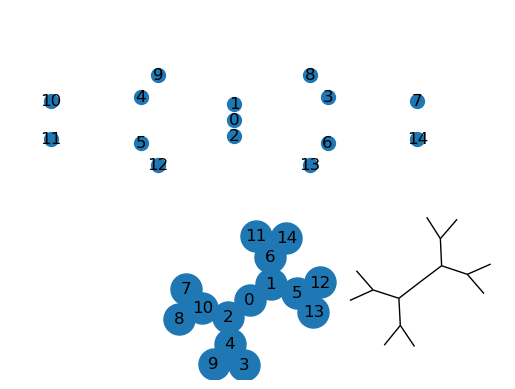

In [4]:
import importlib
import matplotlib.pyplot as plt

import graph_gen
importlib.reload(graph_gen)
fig, (ax0, ax1) = plt.subplots(2,1)
N, J_interaction, G, pos = graph_gen.tree_interaction(Degree,Height)
nx.draw(G, pos, ax=ax0, node_size=100,  with_labels=True)

inter_H = 0
H = inter_H * (2.* np.random.random(N) - 1)
#H = np.zeros(N)

num_swap = 3
J_interaction_rand, H_rand = graph_gen.order_rand(N, 
                                                  J_interaction, 
                                                  H, num_swap=num_swap)

graph_gen.plot_matrix_graph(J_interaction_rand, ax1)

betas = np.arange(1e-6,2,1e-2)
betas_fast = np.arange(0.1,2,4e-1)

j_start = 1
j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

# Exact solutions
enumerating all configurations.

In [5]:
from python_lib.models import spins_model
importlib.reload(models)
tree = spins_model.model(N, H, J, J_interaction)
tree_rand = spins_model.model(N, H_rand, J_rand, J_interaction_rand)

In [6]:
beta = 0.5
tree.exact(beta)
tree_rand.exact(beta);

beta: 0.5, Fe: -2.196 Energy: -1.42 M: 4.1e-09 S: -0.324
beta: 0.5, Fe: -2.196 Energy: -1.42 M: 8.79e-09 S: -0.324


# Neural network solutions
## ordered case

In [7]:
from python_lib.nets import bp_nn
importlib.reload(bp_nn)
bias = True
net = bp_nn.bp_nn(tree.N, tree, bias, z2=False)
net.train(beta=beta, 
          lr=0.001, 
        batch_size=1000,
 )
net.compute_stat_is(beta, batch_size=5000)

 0.50 6874 fe: -2.196 +- 0.00010 E: -1.436, S: 0.380, M: 0.0232, B1 = -0.0000
free_energy: -2.196,  std_fe: 0.00000, mag_mean: 0.013, entropy: 0.390 energy: -1.417

tensor(-2.1960, dtype=torch.float64)

In [8]:
net.compute_stat(beta, batch_size=50000)


free_energy: -2.196,  std_fe: 0.00011, mag_mean: 0.002, entropy: 0.386 energy: -1.423

tensor(-2.1960, dtype=torch.float64)

## random case

In [9]:
from python_lib.nets import bp_nn
importlib.reload(bp_nn)

net_rand = bp_nn.bp_nn(tree_rand.N, tree_rand, True, z2=False, init_zero=False,)
                      
net_rand.train(beta=beta, lr=0.001, 
           max_step=1000,
               opt="adam")


 0.50 1000 fe: -1.881 +- 0.29479 E: -0.776, S: 0.552, M: 0.321, B1 = -1.276

{'free_energy_mean': tensor(-1.8812, dtype=torch.float64),
 'free_energy_std': tensor(0.2948, dtype=torch.float64),
 'entropy_mean': tensor(0.5525, dtype=torch.float64, grad_fn=<DivBackward0>),
 'energy_mean': tensor(-0.7763),
 'mag': tensor([-0.5740, -0.5420, -0.4920, -0.1980, -0.4120, -0.3880, -0.5000,  0.0440,
         -0.0960, -0.3180, -0.2120, -0.3380, -0.2620, -0.2540, -0.1780]),
 'mag_mean': tensor(0.3205)}

In [10]:
net_rand.compute_stat_is(beta, batch_size=10000)


free_energy: -2.175,  std_fe: 0.00144, mag_mean: 0.200, entropy: 0.415 energy: -1.346

tensor(-2.1748, dtype=torch.float64)

# BP solution

In [14]:
import bp_solver
importlib.reload(bp_solver)

bp_sol = bp_solver.BP_solver(tree_rand)

In [15]:
beta

0.5

In [16]:
bp_sol.converge(beta)

fe: -1.611, ener: -0.431, M: 0.000, iter 5
